<a href="https://colab.research.google.com/github/ben-oxley/colab-opencl-experiments/blob/main/CUDA-Planet-Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
!pip install pycuda
%load_ext nvcc_plugin

Thu May  4 09:04:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy
num_planets = 2
n_dims = 2
planet_mass = numpy.random.uniform(1e5,1e10,num_planets)
planet_locations = numpy.random.uniform(0,1e12,(num_planets,n_dims))
planet_forces = numpy.zeros((num_planets,n_dims))
planet_velocity = numpy.random.uniform(0,1e5,(num_planets,n_dims))
#Convert to single precision for GPU support

planet_locations = planet_locations.astype(numpy.float32)
planet_mass = planet_mass.astype(numpy.float32)
planet_forces = planet_forces.astype(numpy.float32)
planet_velocity = planet_velocity.astype(numpy.float32)

planet_forces_gpu_buffer = cuda.mem_alloc(planet_forces.nbytes)
cuda.memcpy_htod(planet_forces_gpu_buffer, planet_forces)

planet_locations_gpu_buffer = cuda.mem_alloc(planet_locations.nbytes)
cuda.memcpy_htod(planet_locations_gpu_buffer, planet_locations)

planet_mass_gpu_buffer = cuda.mem_alloc(planet_mass.nbytes)
cuda.memcpy_htod(planet_mass_gpu_buffer, planet_mass)

planet_velocity_gpu_buffer = cuda.mem_alloc(planet_velocity.nbytes)
cuda.memcpy_htod(planet_velocity_gpu_buffer, planet_velocity)

locs = numpy.copy(planet_locations)

In [19]:
mod = SourceModule("""
#include <stdio.h>
  __global__ void calculate_forces(float2 *locations, float *masses, float2 *forces)
  {
    for (int i = 0; i < 2; i += 1) {
      int idx = (int)threadIdx.x;
      if (idx != i) {
        float distancex = locations[i].x-locations[idx].x;
        float distancey = locations[i].y-locations[idx].y;
        float distance2 = (distancex*distancex)+(distancey*distancey);
        float distance = sqrt(distance2);
        float masscomponent = 6.67408e-11*masses[idx]*masses[i];
        forces[idx].x += distancex*masscomponent/distance;
        forces[idx].y += distancey*masscomponent/distance;
      }
    }
  }

   __global__ void calculate_new_velocity(float2 *velocities, float *masses, float2 *forces)
  {
    float seconds = 100000;
    int idx = (int)threadIdx.x;
    velocities[idx].x += seconds*forces[idx].x/masses[idx];
    velocities[idx].y += seconds*forces[idx].y/masses[idx];
  }

   __global__ void calculate_new_locations(float2 *velocities, float2 *locations)
  {
    float seconds = 100000;
    int idx = (int)threadIdx.x;
    locations[idx].x += seconds*velocities[idx].x;
    locations[idx].y += seconds*velocities[idx].y;
  }

   __global__ void to_canvas(float2 *locations, float *canvas)
  {
    int gid = (int)threadIdx.x;
    int x = (int)locations[gid].x;
    int y = (int)(locations[gid].y*1000);
    canvas[x+y] +=1;
  }
  
  """)



Locations:
[[ 4.8784091e+11  2.9605832e+11]
 [-2.3695347e+11  5.8536506e+11]]
Forces:
[[ 2.258786e+08 -2.948784e+08]
 [-2.258786e+08  2.948784e+08]]
Velocities:
[[ 412267.56 -144007.86]
 [-879745.06  550333.7 ]]


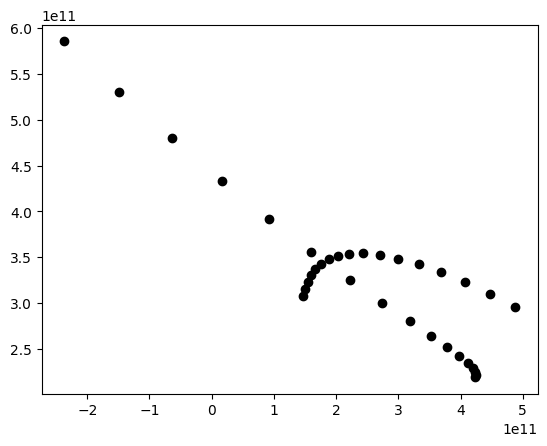

In [48]:
# print("Mass:")
# print(planet_mass)
# print("Locations:")
# print(planet_locations)
# print("Forces:")
# print(planet_forces)
# print("Velocities:")
# print(planet_velocity)

func = mod.get_function("calculate_forces")
func(planet_locations_gpu_buffer,planet_mass_gpu_buffer,planet_forces_gpu_buffer, block=(num_planets,1,1))
func = mod.get_function("calculate_new_velocity")
func(planet_velocity_gpu_buffer,planet_mass_gpu_buffer,planet_forces_gpu_buffer, block=(num_planets,1,1))
func = mod.get_function("calculate_new_locations")
func(planet_velocity_gpu_buffer,planet_locations_gpu_buffer, block=(num_planets,1,1))
cuda.memcpy_dtoh(planet_mass, planet_mass_gpu_buffer)
cuda.memcpy_dtoh(planet_locations, planet_locations_gpu_buffer)
cuda.memcpy_dtoh(planet_forces, planet_forces_gpu_buffer)
cuda.memcpy_dtoh(planet_velocity, planet_velocity_gpu_buffer)
# print("Mass:")
# print(planet_mass)
print("Locations:")
print(planet_locations)
print("Forces:")
print(planet_forces)
print("Velocities:")
print(planet_velocity)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
locs = numpy.append(locs,planet_locations,0)
plt.plot(locs[:,0],locs[:,1], 'o', color='black');

In [21]:
from PIL import Image
from IPython.display import display
canvas = numpy.zeros((1000,1000))
canvas = canvas.astype(numpy.float32)
canvas_gpu_buffer = cuda.mem_alloc(canvas.nbytes)
cuda.memcpy_htod(canvas_gpu_buffer,canvas)
func = mod.get_function("to_canvas")
func(planet_locations_gpu_buffer,canvas_gpu_buffer, block=(num_planets,1,1))
cuda.memcpy_dtoh(canvas, canvas_gpu_buffer)
print(canvas)
max = canvas.max()
print(max)
img = Image.fromarray(np.uint8(canvas/max * (255)) , 'L')
img.show()
display(img)

LogicError: ignored